In [1]:
from __future__ import division, print_function, absolute_import

import math
import time
import sys
import cv2
import os
import random
import itertools
from pathlib import Path
import enum
import multiprocessing
from pathlib import Path

import numpy as np
from unet import UNet

import numpy as np
from PIL import Image
from os import listdir
from os.path import join, basename, isdir
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from skimage.color import gray2rgb
from tqdm.notebook import trange, tqdm, tqdm_notebook
import scipy
from scipy import stats
from scipy import ndimage
import h5py
import zipfile
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as im
import matplotlib.image as img
from matplotlib import style
import nibabel as nb
from nibabel.testing import data_path
import SimpleITK as sitk
from ipywidgets import interact, fixed
from IPython import display
from tqdm.notebook import tqdm
from pathlib import Path



%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.utils 
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Lambda
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split, SubsetRandomSampler

import torch
import torchio as tio
from torchio.transforms import HistogramStandardization
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter



In [3]:
print('TorchIO version:', tio.__version__)
print('Torch version:', tio.__version__)

TorchIO version: 0.18.51
Torch version: 0.18.51


In [4]:
cuda = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [5]:
torch.cuda.is_available()

True

# Visulization Randomly from Train_Dataset

In [6]:
# Download all Train and Valid dataset 
train_dataset = datasets.FashionMNIST(
    root = 'data',
    train = True,                         
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5))]), 
    download = True            
)
                                    
test_dataset = datasets.FashionMNIST(
    root = 'data', 
    train = False, 
    download = True,
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5))]), 
)

C:\Users\mshabani\AppData\Local\Continuum\anaconda3\envs\Torch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
print(train_dataset.data.size())

torch.Size([60000, 28, 28])


In [8]:
print(train_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


In [9]:
print(test_dataset)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


In [10]:
#10 types of clothes in FashionMNIST
def Class_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

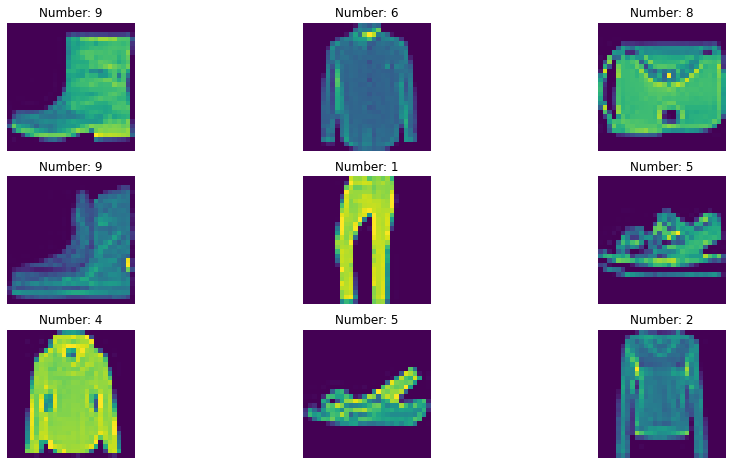

In [11]:
figure = plt.figure(figsize=(15, 8))
colums, rows = 3, 3
for i in range(1, colums * rows + 1):
    sample = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample]
    figure.add_subplot(rows, colums, i)
    plt.title('Number: %i' % label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

In [12]:
# split = int(np.floor(0.2*len(train_dataset)))

# 2D CNN Model

In [13]:
# Asked Model

class MNIST(nn.Module):
    def __init__(self):
        super(MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, 3)
        self.conv2 = nn.Conv2d(32, 64, 4, 3)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
 
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [14]:
model_request = MNIST()
print(model_request)

MNIST(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(3, 3))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(3, 3))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [15]:
class CNN(nn.Module):
    def __init__(self,h1=128):
        # We optimize dropout rate in a convolutional neural network.
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=0.5)   

        self.fc1 = nn.Linear(32 * 7 * 7, h1) # in_features=32 * 7 * 7, out_features=96
        self.drop2=nn.Dropout2d(p=0.1)

        self.fc2 = nn.Linear(h1, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))

        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop2(x)

        x = self.fc2(x)

        return x
    
model = CNN()

In [16]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (drop1): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (drop2): Dropout2d(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [17]:
# define Loss_Function/ Optimizer/ #epoch/ #Fold 

criterion = nn.CrossEntropyLoss()
num_epochs=10
batch_size=64
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldk={}

In [18]:
def Train_model(model,device,dataloader,losses,optimizer):
    train_loss,train_correct=0.0,0.0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = losses(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def Val_model(model,device,dataloader,losses):
    valid_loss, val_correct = 0.0, 0.0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=losses(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [19]:
dataset = ConcatDataset([train_dataset, test_dataset])

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('_____________________________________')
    
    print('FMNIST_FOLD {}'.format(fold + 1))
    
    print('_____________________________________')      

    
    # Define data loaders for training and validation data through 5fold

    train_ds = SubsetRandomSampler(train_idx)
    test_ds = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_ds)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_ds)

    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cuda = True
    model=CNN()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {'train_loss': [], 
               'test_loss': [],
               'train_acc':[],
               'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=Train_model(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=Val_model(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} Ave_Training Loss:{:.3f} Ave_Test Loss:{:.3f} Ave_Training Acc {:.2f} % Ave_Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldk['fold{}'.format(fold+1)] = history  

torch.save(model,'kfold_FashionMNIST_CNN.pt') 

_____________________________________
FMNIST_FOLD 1
_____________________________________


C:\Users\mshabani\AppData\Local\Continuum\anaconda3\envs\Torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:1/10 Ave_Training Loss:0.548 Ave_Test Loss:0.353 Ave_Training Acc 80.18 % Ave_Test Acc 87.03 %
Epoch:2/10 Ave_Training Loss:0.369 Ave_Test Loss:0.305 Ave_Training Acc 86.67 % Ave_Test Acc 88.96 %
Epoch:3/10 Ave_Training Loss:0.325 Ave_Test Loss:0.276 Ave_Training Acc 88.32 % Ave_Test Acc 89.88 %
Epoch:4/10 Ave_Training Loss:0.296 Ave_Test Loss:0.267 Ave_Training Acc 89.13 % Ave_Test Acc 90.06 %
Epoch:5/10 Ave_Training Loss:0.276 Ave_Test Loss:0.253 Ave_Training Acc 89.95 % Ave_Test Acc 90.75 %
Epoch:6/10 Ave_Training Loss:0.260 Ave_Test Loss:0.248 Ave_Training Acc 90.36 % Ave_Test Acc 90.66 %
Epoch:7/10 Ave_Training Loss:0.248 Ave_Test Loss:0.237 Ave_Training Acc 90.78 % Ave_Test Acc 91.39 %
Epoch:8/10 Ave_Training Loss:0.238 Ave_Test Loss:0.240 Ave_Training Acc 91.15 % Ave_Test Acc 91.19 %
Epoch:9/10 Ave_Training Loss:0.230 Ave_Test Loss:0.229 Ave_Training Acc 91.49 % Ave_Test Acc 91.56 %
Epoch:10/10 Ave_Training Loss:0.222 Ave_Test Loss:0.224 Ave_Training Acc 91.83 % Ave_Test A

In [20]:
# Define the Average 

test_loss_f = []
train_loss_f = []
test_acc_f= []
train_acc_f = []
k=5

for f in range(1,k+1):

     train_loss_f.append(np.mean(foldk['fold{}'.format(f)]['train_loss']))
     test_loss_f.append(np.mean(foldk['fold{}'.format(f)]['test_loss']))

     train_acc_f.append(np.mean(foldk['fold{}'.format(f)]['train_acc']))
     test_acc_f.append(np.mean(foldk['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(train_loss_f),np.mean(test_loss_f),np.mean(train_acc_f),np.mean(test_acc_f)))     


Performance of 5 fold cross validation
Average Training Loss: 0.300 	 Average Test Loss: 0.261 	 Average Training Acc: 89.06 	 Average Test Acc: 90.44


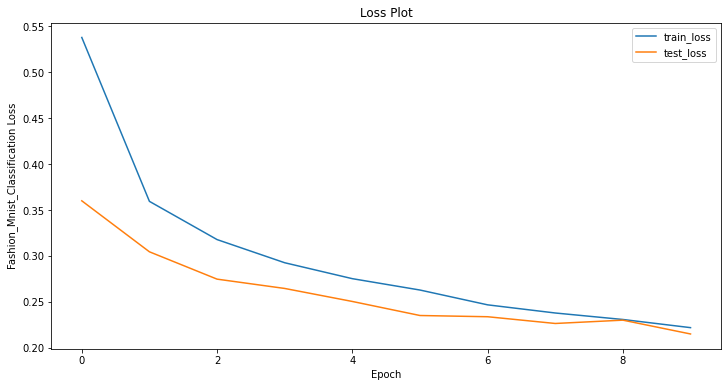

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Fashion_Mnist_Classification Loss')
plt.title('Loss Plot')
plt.show()

Text(0.5, 1.0, 'Accuracy Plot')

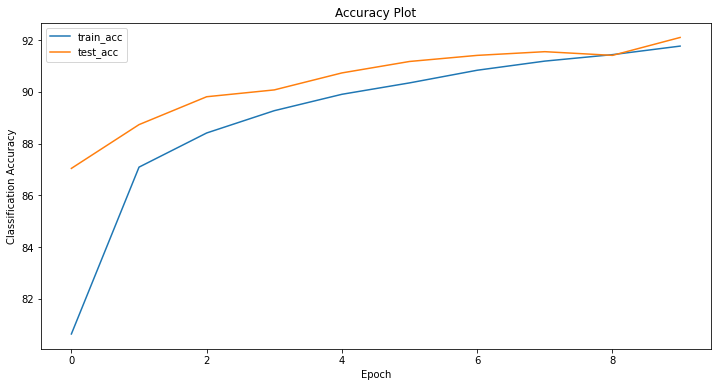

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['test_acc'], label='test_acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Classification Accuracy')
plt.title('Accuracy Plot')

# Cinfusion Matrix

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1415
           1       0.99      0.99      0.99      1407
           2       0.89      0.88      0.88      1379
           3       0.93      0.91      0.92      1381
           4       0.85      0.89      0.87      1357
           5       0.99      0.98      0.98      1448
           6       0.79      0.75      0.77      1434
           7       0.96      0.97      0.96      1403
           8       0.99      0.98      0.98      1426
           9       0.97      0.97      0.97      1350

    accuracy                           0.92     14000
   macro avg       0.92      0.92      0.92     14000
weighted avg       0.92      0.92      0.92     14000



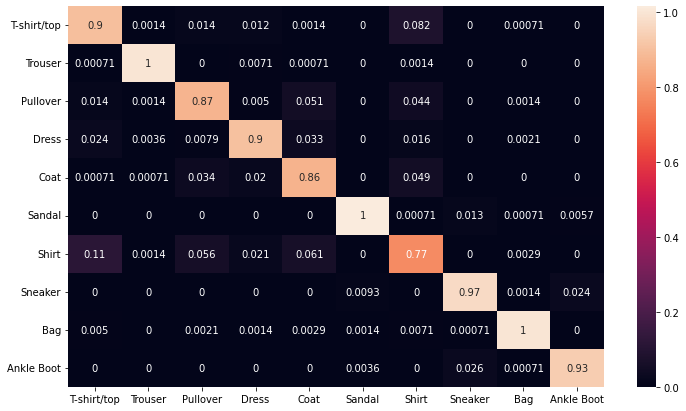

In [23]:
# Cinfusion Matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs.cuda()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.ylabel('True label', fontsize=12, color='darkblue') # fontweight='bold'
plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}', fontsize=12, color='darkblue')
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')
print(classification_report(y_true, y_pred))

# Statistical Metrices 

In [24]:
# Overall Statistics and  Class Statistics metrices
from pycm import *

cm = ConfusionMatrix(y_true, y_pred)
cm.table
print(cm)

Predict    0          1          2          3          4          5          6          7          8          9          
Actual
0          1259       2          19         17         2          0          115        0          1          0          

1          1          1393       0          10         1          0          2          0          0          0          

2          19         2          1216       7          72         0          61         0          2          0          

3          34         5          11         1260       46         0          22         0          3          0          

4          1          1          47         28         1211       0          69         0          0          0          

5          0          0          0          0          0          1420       1          18         1          8          

6          159        2          78         29         85         0          1077       0          4          0          

7         

C:\Users\mshabani\AppData\Local\Continuum\anaconda3\envs\Torch\lib\site-packages\pycm\pycm_obj.py:205: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


# Grad_CAM on Test dataset

In [25]:
#!pip install grad_cam

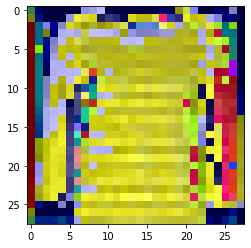

In [31]:
# https://pypi.org/project/grad-cam/

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.conv1]

inputs, labels = next(iter(test_loader),20)  
input_tensor = inputs.cuda()[0:1]
rgb_img = input_tensor.cpu().numpy().squeeze()
rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_GRAY2RGB)
rgb_img[rgb_img==-1]=0
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# If target_category is None, the highest scoring category
# will be used for every image in the batch.
# target_category can also be an integer, or a list of different integers
# for every image in the batch.
target_category = labels[0:1]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
plt.imshow(visualization)